In [23]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [13]:
!pip install keras_cv -q

In [14]:
!pip install --upgrade keras

In [15]:
!pip install segmentation_models

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras import ops
import keras_cv
import numpy as np
import segmentation_models as sm
from keras_cv.datasets.pascal_voc.segmentation import load as load_voc
from tensorflow.keras import backend as K
# Define the U-Net model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
train_ds = load_voc(split="sbd_train")
eval_ds = load_voc(split="sbd_eval")


1419539633/1419539633 ━━━━━━━━━━━━━━━━━━━━ 803s 1us/step


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [7]:
print(train_ds)

<_FlatMapDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'class_segmentation': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'object_segmentation': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>


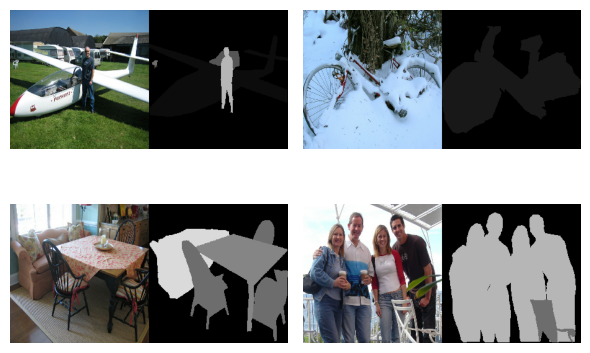

In [8]:

def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=224, width=224))
    outputs = outputs.batch(32, drop_remainder=True)
    return outputs

train_ds = preprocess_tfds_inputs(train_ds)
eval_ds = preprocess_tfds_inputs(eval_ds)

batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)


In [9]:
eval_ds = preprocess_tfds_inputs(eval_ds)

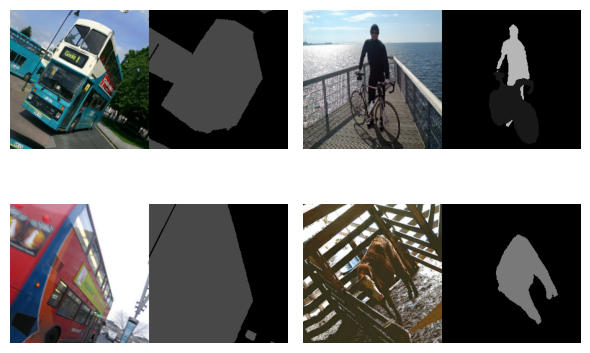

In [17]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
train_ds = train_ds.map(keras_cv.layers.RandomRotation(factor=.1, segmentation_classes=21))

batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)


In [10]:
def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool1)
    # Concatenate
    merge1 = concatenate([conv1, up1], axis=3)
    # Final output
    outputs = Conv2D(21, 1, activation='softmax')(merge1)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()


In [11]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [18]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Compile the model
model.compile(optimizer='adam', loss=total_loss, metrics=['accuracy', jaccard_coef])


In [25]:
metrics=['accuracy', jaccard_coef]
#compile the model
####################
#your code goes here
model.compile(optimizer='adam', loss=total_loss, metrics=['accuracy', jaccard_coef])
####################

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 224, 224, 64)   │         16,448 │ max_pooling2d[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 224, 224, 128)  │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 3)    │            387 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,627 (72.76 KB)

 Trainable params: 18,627 (72.76 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:

# Function to convert dictionary to tuple and handle one-hot encoding
def dict_to_tuple(x):
    images = x["images"]
    masks = tf.one_hot(tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), tf.int32), 21)
    return images, masks

train_ds = train_ds.map(lambda x: dict_to_tuple(x))
eval_ds = eval_ds.map(lambda x: dict_to_tuple(x))

# Define ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_jaccard_coef',
    save_best_only=True,
    mode='max'
)


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


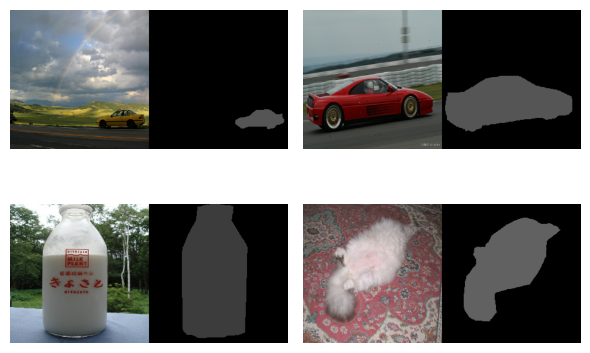

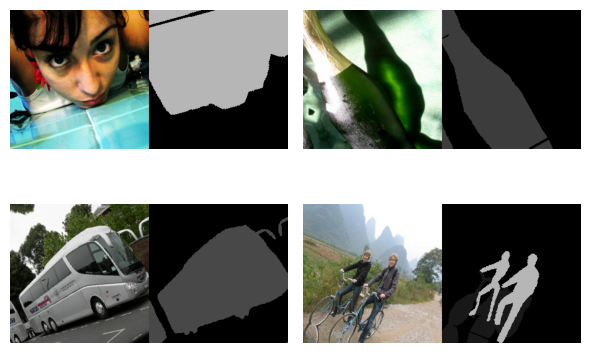

In [ ]:
model.fit(train_ds, validation_data=eval_ds, epochs=10, callbacks=[checkpoint_callback])


Epoch 1/10
    265/Unknown 2663s 10s/step - accuracy: 0.5965 - jaccard_coef: 0.4067 - loss: 1.0035

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


265/265 ━━━━━━━━━━━━━━━━━━━━ 2985s 11s/step - accuracy: 0.5965 - jaccard_coef: 0.4066 - loss: 1.0035 - val_accuracy: 0.5873 - val_jaccard_coef: 0.2752 - val_loss: 0.9520
Epoch 2/10
115/265 ━━━━━━━━━━━━━━━━━━━━ 25:26 10s/step - accuracy: 0.6185 - jaccard_coef: 0.3111 - loss: 0.9606

In [ ]:
activation='softmax'

LR = 0.001 #
optim = keras.optimizers.Adam(LR) #


dice_loss = sm.losses.DiceLoss() #
focal_loss = sm.losses.CategoricalFocalLoss() #
total_loss = dice_loss + (1 * focal_loss) #


In [ ]:
BACKBONE1 = 'mobilenetv2'

n_classes=21
metrics=['accuracy', jaccard_coef]
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optimizer=optim, loss=total_loss, metrics=['accuracy', jaccard_coef])

print(model1.summary())

In [ ]:
flag = True
for l in model1.layers:
    if l.name == 'decoder_stage0_upsampling':
        flag = False
    if flag:
        l.trainable = False

# Define another ModelCheckpoint callback for the second model
checkpoint_callback1 = ModelCheckpoint(
    filepath='best_model1.h5',
    monitor='val_jaccard_coef',
    save_best_only=True,
    mode='max'
)


In [ ]:
model1.summary()

In [ ]:
# model1.fit(train_ds, validation_data=eval_ds, epochs=10, batch_size=32 )
model1.fit(train_ds, validation_data=eval_ds, epochs=10,
           batch_size=32 ,callbacks=[checkpoint_callback1])


In [ ]:
#let all the layers be trained
####################
#your code goes here
for l in model1.layers:
    l.trainable = True
####################

In [ ]:
LR = 0.000005
optim = keras.optimizers.Adam(LR)

In [ ]:
model1.compile(optim, total_loss, metrics=metrics)

In [ ]:
# model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32 )
model1.fit(train_ds, validation_data=eval_ds, epochs=5, batch_size=32, callbacks=[checkpoint_callback1])
